In [8]:
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [9]:
X, Y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=3.0, 
                           center_box=(-5.0, 5.0), shuffle=True, random_state=None)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)


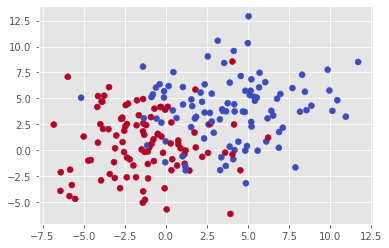

In [11]:
plt.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm')

In [12]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

with pm.Model() as model:
    # Below we require an ordering of the summed weights, thus initialize in this order
    init_1 = np.random.randn(X.shape[1], 3)
    init_1 = init_1[:, np.argsort(init_1.sum(axis=0))]
    init_2 = np.random.randn(3)
    init_2 = init_2[np.argsort(init_2)]
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], 3), 
                             testval=init_1)
    # Weights from hidden layer to output
    weights_1_out = pm.Normal('w_1_out', 0, sd=1, shape=(3,), 
                              testval=init_2)

    # As the hidden neurons are interchangeable this induces a symmetry in the posterior.
    # This is my first attempt at breaking that symmetry. I'm not sure if it's actually
    # correct or if there is a better way to do it. It seems to work for this toy model.
    pm.Potential(
        'order_means_potential',
        T.switch(T.ge(T.sum(weights_in_1[:, 0]), T.sum(weights_in_1[:, 1])), -np.inf, 0)
        + T.switch(T.ge(T.sum(weights_in_1[:, 1]), T.sum(weights_in_1[:, 2])), -np.inf, 0))

    # Not sure if this is required...
    pm.Potential(
        'order_means_potential2',
        T.switch(T.ge(weights_1_out[0], weights_1_out[1]), -np.inf, 0)
        + T.switch(T.ge(weights_1_out[1], weights_1_out[2]), -np.inf, 0))
    
    # Do forward pass
    a1 = T.dot(ann_input, weights_in_1)
    act_1 = T.nnet.sigmoid(a1)
    act_out = T.dot(act_1, weights_1_out)
    
    out = pm.Bernoulli('out', 
                       T.nnet.sigmoid(act_out),
                       observed=ann_output)
    
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step)



/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_38797/708291358.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(50000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_1_out]
>Metropolis: [w_in_1]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 28 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


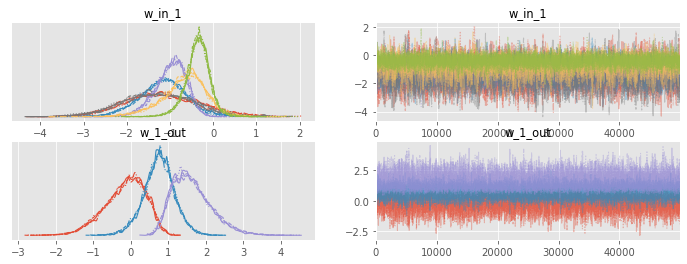

In [13]:
pm.plot_trace(trace);

In [14]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model=model, samples=5000)
pred = ppc['out'].mean(axis=0) > 0.5

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1698: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


Text(0.5, 1.0, 'Predicted labels in testing set')

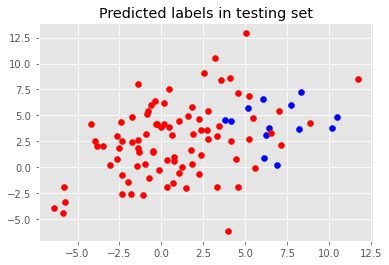

In [15]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1], color='b')
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

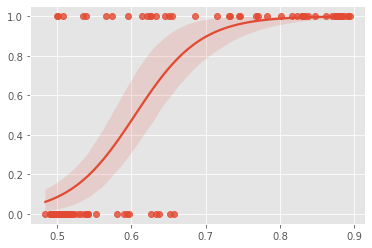

In [16]:
import seaborn as sns
sns.regplot(ppc['out'].mean(axis=0), Y_test, logistic=True)

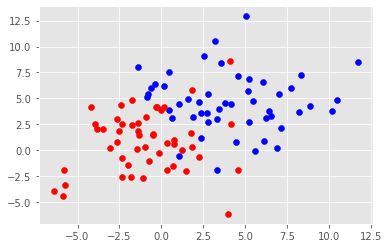

In [17]:
plt.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1], color='b')
plt.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')

In [18]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))


Accuracy = 63.0%


### Try regression model

In [42]:
X = np.linspace(0, 100, 200)
Y = np.sin(0.05*X) + np.random.normal(0,.1,size=200)

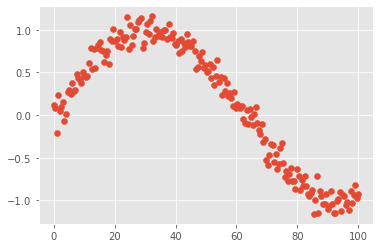

In [43]:
plt.scatter(X, Y)

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.1)

In [109]:
ann_input = theano.shared(X.reshape(-1,1))
ann_output = theano.shared(Y)

with pm.Model() as model:
    init_1 = np.random.randn(X.shape[1], 20)
    init_2 = np.random.randn(20)
    #init_bias_1 = np.random.randn(3)
    #init_bias_2 = np.random.randn(1)
    #
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], 20), 
                             testval=init_1)
    # Weights from hidden layer to output
    weights_1_out = pm.Normal('w_1_out', 0, sd=1, shape=(20,), 
                              testval=init_2)
    
   # bias_1 = pm.Normal('bias_1', 0, sd=1e3, shape=(3,), 
               #              testval=init_bias_1)
    #bias_2 = pm.Normal('bias_2', 0, sd=1e3, shape=(1,), 
                    #         testval=init_bias_2)

    #eps = pm.Uniform("eps", lower=0.0, upper=10000)
    
    # Do forward pass
    a1 = T.dot(ann_input, weights_in_1) #+ bias_1
    act_1 = T.nnet.relu(a1)#+ bias_2
    act_out = T.dot(act_1, weights_1_out)

    
    out = pm.Normal('out', 
                       T.nnet.relu(act_out),sd=1,
                       observed=ann_output)
    
    step = pm.Metropolis()
    trace = pm.sample(50000, step=step)

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_38797/67821586.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(50000, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [w_1_out]
>Metropolis: [w_in_1]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 38 seconds.
The number of effective samples is smaller than 10% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


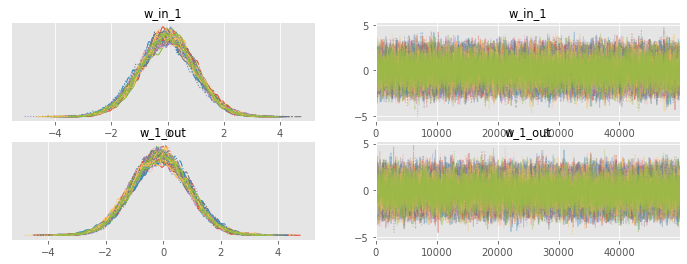

In [110]:
pm.plot_trace(trace);

In [111]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=5000)
pred = ppc['out'].mean(axis=0) 

/Users/juliette/opt/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


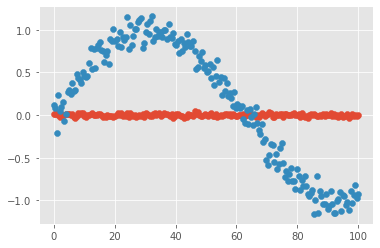

In [112]:
plt.scatter(X, pred)
plt.scatter(X, Y)